In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression

In [2]:
stop_words = set(stopwords.words('english')).union({'', 'would'})

In [3]:
train_df = pd.read_csv("train_df.csv")
test_df = pd.read_csv("test_df.csv")
train_df["num_label"] = train_df["num_label"].astype('category')
test_df["num_label"] = test_df["num_label"].astype('category')

In [4]:
train_df.head(10)

,file_id,user_id,subforum_id,num_contexts,post,comment_id,sentence_num,num_label,preprocessed_post
0,30614073_4,573925,1362,0,Thanks for the idea 's ...,30614073,4,0,thank for the idea s ...
1,12848217_16,575810,1346,0,"It wasnt really that dangerous perse , just st...",12848217,16,1,it wasnt realli that danger pers just stinki a...
2,30641037_2,572480,1359,0,The jew is attempting to make the condemned be...,30641037,2,1,the jew is attempt to make the condemn beg for...
3,13273318_1,573473,1345,0,I've heard the name before but I too have no i...,13273318,1,1,ive heard the name before but i too have no id...
4,30739023_9,572817,1362,0,Q : If Johnny was at his own 10 yard line when...,30739023,9,0,q : if johnni was at his own _number_ yard lin...
5,30405398_3,572191,1396,2,In fact here at home their involvement in Nige...,30405398,3,0,in fact here at home their involv in nigeria i...
6,13552491_3,576755,1346,0,Blacks and mexicans were represented thoroughl...,13552491,3,1,black and mexican were repres thoroughly. do y...
7,14014174_1,576515,1388,0,Looks like some Jews good broken into their ca...,14014174,1,1,look like some jew good broken into their car ...
8,30698686_1,573431,1354,0,I've seen those walls in Cuzco .,30698686,1,0,ive seen those wall in cuzco .
9,30451625_3,577167,1388,0,I went back a cpl years ago and the black verm...,30451625,3,1,i went back a cpl year ago and the black vermi...


In [5]:
def filtered_word_array(ting):
    curr_stop_words = stop_words.union({".", "\"", ",", ":", "...", "'s", "n't", "'m", "(", ")", "'", "-", "``", "?", "!", "/"})
    return [x for x in ting.split(" ") if x not in curr_stop_words]

def top_keywords(data, classes, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(classes).mean()
    class_dict = {}
    for class_name, row in df.iterrows():
        class_dict[class_name] = Counter({word: weight for word, weight in zip([labels[t] for t in np.argsort(row)[-n_terms:]], np.argsort(row)[-n_terms:])})
    return class_dict

def top_tokens(counts, n, ax, title, x_label='Token', y_label='Count'):
    total_words = sum(counts.values())
    top_counts = pd.DataFrame(counts.most_common(n), columns=[x_label, y_label])
    plot = sns.barplot(x=x_label, y=y_label, data=top_counts, ax=ax)
    plot.set_xticklabels(labels=top_counts[x_label], rotation=80)
    ax.set_title(title, fontsize='15')
    ax.tick_params(labelsize='13')
    return ax

## Most Common Words in Hate (1) vs Not Hate (0)
- Not that many of the words normally associated with toxicity are not present

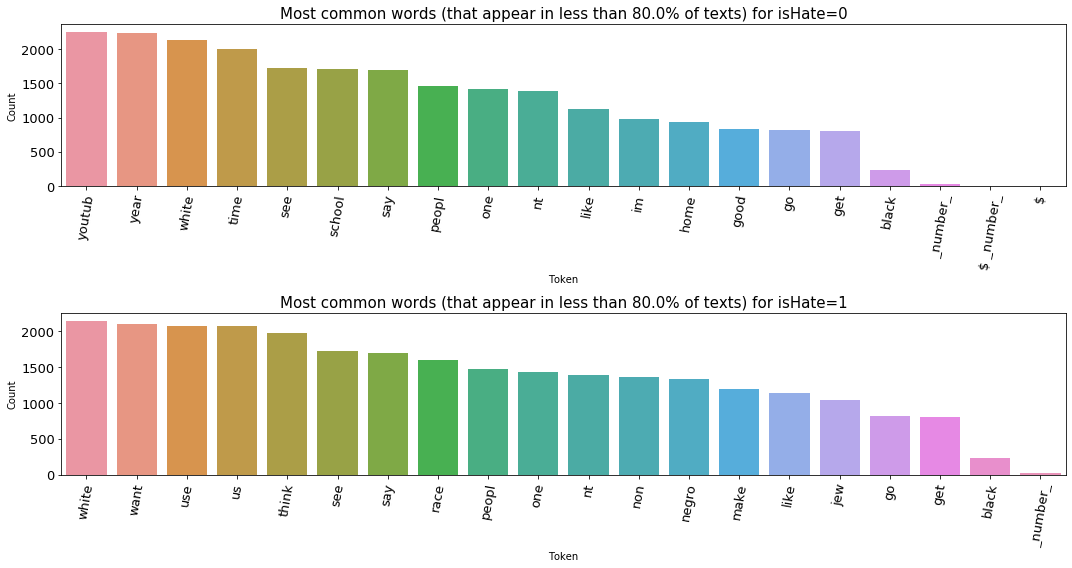

In [6]:
max_df = 0.8
count_vectorizer = CountVectorizer(max_df=max_df, min_df=2, tokenizer=filtered_word_array, ngram_range=(1,2))
count_matrix = count_vectorizer.fit_transform(train_df["preprocessed_post"].tolist()) #fit the vectorizer to synopses
top_count_class_keywords = top_keywords(count_matrix, [str(x) for x in train_df.num_label.tolist()], count_vectorizer.get_feature_names(), 20)
# print(top_count_class_keywords)
# Find most frequent tokens for each class
fig, ax = plt.subplots(2, 1, figsize=(15, 8))
for idx, label in enumerate(["0", "1"]):
  ax[idx] = top_tokens(top_count_class_keywords[label], 20, ax[idx], "Most common words (that appear in less than {}% of texts) for isHate={}".format(max_df*100, label))
plt.tight_layout()
plt.show()

## Highest TF-IDF Weightings in Hate (1) vs Not Hate (0)

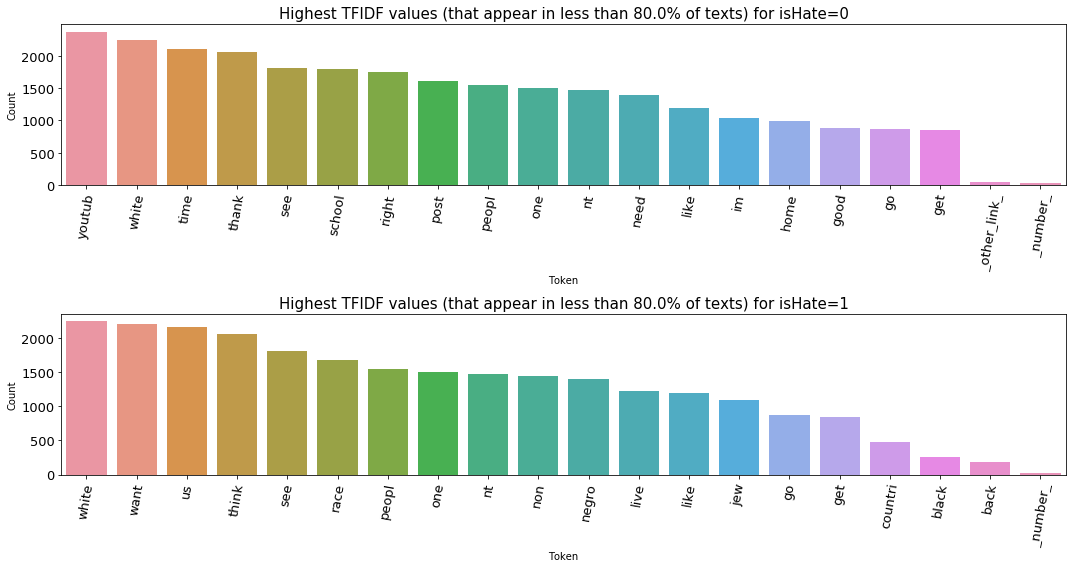

In [7]:
max_df = 0.8
tfidf_vectorizer = TfidfVectorizer(max_df=max_df, min_df=2, use_idf=True, tokenizer=filtered_word_array, ngram_range=(1,4))
tfidf_matrix = tfidf_vectorizer.fit_transform(train_df["preprocessed_post"].tolist()) #fit the vectorizer to synopses
top_class_keywords = top_keywords(tfidf_matrix, [str(x) for x in train_df.num_label.tolist()], tfidf_vectorizer.get_feature_names(), 20)
fig, ax = plt.subplots(2, 1, figsize=(15, 8))
for idx, label in enumerate(["0", "1"]):
  ax[idx] = top_tokens(top_class_keywords[label], 20, ax[idx], "Highest TFIDF values (that appear in less than {}% of texts) for isHate={}".format(max_df*100, label))
plt.tight_layout()
plt.show()

## Create Classifier using a combination of BOW and TF-IDF
- Try using both logicstic regression, and an SVM with an RBF kernel
- SVMs are supposed to be best for text stuff but surprisingly this was not the case

In [8]:
class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.field]

In [9]:
preprocessing_pipeline = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('colext', TextSelector("preprocessed_post")),
            ('tfidf', TfidfVectorizer(max_df=0.8, min_df=2, use_idf=True, tokenizer=filtered_word_array, ngram_range=(1,4)))
        ])),
        ('bow', Pipeline([
            ('colext', TextSelector("preprocessed_post")),
            ('bow', CountVectorizer(max_df=0.8, min_df=2, tokenizer=filtered_word_array, ngram_range=(1,4)))
        ]))
    ]))
])
svm_rbf = Pipeline(steps=[('yeet', preprocessing_pipeline),
                      ('classifier', SVC(probability=True, gamma='scale', kernel='rbf'))])
log_reg = Pipeline(steps=[('yeet', preprocessing_pipeline),
                        ('classifier', LogisticRegression())])

In [10]:
log_reg.fit(train_df, train_df["num_label"].tolist())

Pipeline(memory=None,
         steps=[('yeet',
                 Pipeline(memory=None,
                          steps=[('features',
                                  FeatureUnion(n_jobs=None,
                                               transformer_list=[('text',
                                                                  Pipeline(memory=None,
                                                                           steps=[('colext',
                                                                                   TextSelector(field='preprocessed_post')),
                                                                                  ('tfidf',
                                                                                   TfidfVectorizer(analyzer='word',
                                                                                                   binary=False,
                                                                                                   decode_e

In [11]:
svm_rbf.fit(train_df, train_df["num_label"].tolist())

Pipeline(memory=None,
         steps=[('yeet',
                 Pipeline(memory=None,
                          steps=[('features',
                                  FeatureUnion(n_jobs=None,
                                               transformer_list=[('text',
                                                                  Pipeline(memory=None,
                                                                           steps=[('colext',
                                                                                   TextSelector(field='preprocessed_post')),
                                                                                  ('tfidf',
                                                                                   TfidfVectorizer(analyzer='word',
                                                                                                   binary=False,
                                                                                                   decode_e

## Results:
- Logistic regression appears to perform better than the svm (unexpected as svms are supposed to be good at this stuff)
- In general, the incorrectly classified posts don't have any of the preprocessing symbols (except _number_), which suggests the preprocessing is helping
- Often, the language used in these are less specific (ex. dark skinned beings)
- In general this stuff is still subjective: Test index 157: Guess: 0.0 Act: 1 Post: "it s just the way they are ."
    - Could also check 102? 473?
- Snowball stemmer helped a fair bit (makes sense since theres not much data, and some of the words could be hidden in their plural forms
    - Logistic Regression Results (It changes depending on what split you get, but the performance improvement is often there):
        - With Stemmer: 0.7594142259414226
        - With stemmer but removing stopwords: 0.7196652719665272
        - No Stemmer: 0.7238493723849372
- NLTK lemmatizer didnt work as well... probably because it doesnt do that well with handling unknown words, and its results depend on context

In [12]:
log_reg_out = log_reg.predict_proba(test_df)

In [13]:
svm_out = svm_rbf.predict_proba(test_df)

In [14]:
print("Log Reg Accuracy: ", accuracy_score(test_df["num_label"].tolist(), np.round(log_reg_out[:,1])))

Log Reg Accuracy:  0.7364016736401674


In [15]:
print("SVM RBF Accuracy: ", accuracy_score(test_df["num_label"].tolist(), np.round(svm_out[:,1])))

SVM RBF Accuracy:  0.7322175732217573


In [16]:
print("Majority Class Accuracy: ", max(len(test_df[test_df["num_label"] == 1].index), len(test_df[test_df["num_label"] == 0].index))/len(test_df.index))

Majority Class Accuracy:  0.5


In [17]:
for idx, orig_post, post, act, guess, num_contexts in list(zip(test_df.index, test_df.post.tolist(), test_df.preprocessed_post.tolist(), test_df.num_label.tolist(), np.round(log_reg_out[:,1]), test_df.num_contexts.tolist())):
    if guess != act:
        print("Idx: ", idx, "Guess: ", guess, "Act: ", act, "Num Contexts Needed: ", num_contexts)
        print("Post:")
        print(orig_post)
        print("Preprocessed post:")
        print(post)
        print("============================================================================")

Idx:  1 Guess:  0.0 Act:  1 Num Contexts Needed:  1
Post:
And the sad thing is the white students at those schools will act like that too .
Preprocessed post:
and the sad thing is the white student at those school will act like that too .
Idx:  4 Guess:  1.0 Act:  0 Num Contexts Needed:  6
Post:
Excellent Article !! * * * * * Why Were n't They In Jail ?
Preprocessed post:
excel articl _repeatexc_ * _repeatstar_ why were nt they in jail ?
Idx:  5 Guess:  0.0 Act:  1 Num Contexts Needed:  1
Post:
Nevermind, found the new page Knew it had to be a groid .... any report of rape ?
Preprocessed post:
nevermind found the new page knew it had to be a groid ... any report of rape ?
Idx:  7 Guess:  1.0 Act:  0 Num Contexts Needed:  1
Post:
I do n't think anyone is insinuating that we are equal to non whites , or that we would ignore white nations .
Preprocessed post:
i do nt think anyon is insinu that we are equal to non white or that we would ignor white nation .
Idx:  9 Guess:  0.0 Act:  1 Num 

## Possible next steps for performance improvement:
1. Add Extra Columns:
    - What percentage of the user's historical posts are toxic? (user_toxicity)
    - How toxic is the subforum the user is currently on? (subforum_toxicity)
2. Implement cross-validation?
3. Try doing multiple splits, creating a bunch of classifiers, and average the results
4. Get More Data?
5. Try a deep model (after you have more data)?